In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.dummy import DummyRegressor
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import pickle
from scipy.ndimage import shift

In [2]:
train = pd.read_csv("../../kaggle_data/train.csv")
test = pd.read_csv("../../kaggle_data/test.csv")

In [3]:
train = train.loc[np.all(train.notna(), axis=1), :]
train = train.join(pd.get_dummies(train['parentspecies'], dtype=int))
train = train.drop('parentspecies', axis=1)
test.loc[test['parentspecies'].isna(), 'parentspecies'] = 'toluene'
test = test.join(pd.get_dummies(test['parentspecies'], dtype=int))
test = test.drop('parentspecies', axis=1)
dropped_features = ['log_pSat_Pa', 'ID']
train_x = train.loc[:, ~train.columns.isin(dropped_features)]
train_y = train['log_pSat_Pa']
test_x = test.loc[:, ~test.columns.isin(dropped_features)]
test_x.loc[:, 'decane_toluene'] = 0

## Default model scores

In [8]:
dummy = DummyRegressor(strategy='mean')
dummy_scores = cross_val_score(dummy, train_x, train_y, cv=10, scoring='r2')

In [12]:
rf = RandomForestRegressor()
rf_scores = cross_val_score(rf, train_x, train_y, cv=10, scoring='r2')

In [13]:
svm_pipe = make_pipeline(StandardScaler(), SVR())
svm_scores = cross_val_score(svm_pipe, train_x, train_y, cv=10, scoring='r2')

In [ ]:
gb = HistGradientBoostingRegressor()
gb_scores = cross_val_score(gb, train_x, train_y, cv=10, scoring='r2')

0.7443802749508285


In [29]:
models = ['dummy', 'RF', 'SVR', 'GB', 'SVR_linear', 'SVR_Poly_4']
scores = [np.mean(dummy_scores), np.mean(rf_scores), np.mean(svm_scores), np.mean(gb_scores), np.mean(svm_linear_scores), np.mean(svm_poly_scores_dg4)]
score_df = pd.DataFrame({'Models': models, 'Scores': scores})
print(score_df)

       Models    Scores
0       dummy -0.000264
1          RF  0.717607
2         SVR  0.746615
3          GB  0.743940
4  SVR_linear  0.704179
5  SVR_Poly_4  0.634562


In [ ]:
train_pol = train_x.copy()

for column in train_pol.columns:
    if column != 'log_pSat_Pa':
        try:
            train_pol[column] = train_pol[column] ** 2
        except (ValueError, AttributeError):
            pass


## Feature selection

In [10]:
def feature_selection_forward_stepwise(
    model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    features = X_train.columns.values
    fitted_features = []
    fitted_features_stepwise = []
    best_r2_score = 0
    mse_score = 0
    best_feature = None
    r2_scores = []
    mse_scores = []
    
    while features.size:
        for f in features:
            scores = cross_validate(model, X_train.loc[:, np.concatenate([fitted_features, [f]])], y_train, cv=2, scoring=['r2', 'neg_mean_squared_error'])
            if np.mean(scores['test_r2']) > best_r2_score:
                best_feature = f
                best_r2_score = np.mean(scores['test_r2'])
                mse_score = np.mean(scores['test_neg_mean_squared_error'])

        fitted_features.append(best_feature)
        features = features[~np.isin(features, fitted_features)]
        r2_scores.append(best_r2_score)
        mse_scores.append(mse_score)       
        best_r2_score = 0
        mse_score = 0
        best_feature = None
        fitted_features_stepwise.append(list(fitted_features))
    
    return {'fitted_features': fitted_features_stepwise, 'r2_scores': r2_scores, 'mse_scores': mse_scores}
        

In [32]:
def feature_selection_importance(
    feature_importances: pd.Series,
    rfr_model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame | np.ndarray,
):
    r2_scores = []
    mse_scores = []
    
    for i in range(0, feature_importances.shape[0]):
        features = feature_importances.index[0:i+1].to_list()
        model = rfr_model.fit(X_train.loc[:, features], y_train)
        scores = cross_validate(model, X_train.loc[:, features], y_train, cv=3, scoring=['r2', 'neg_mean_squared_error'])
        r2_scores.append(np.mean(scores['test_r2']))
        mse_scores.append(np.mean(scores['test_neg_mean_squared_error']))

    return r2_scores, mse_scores

In [15]:
def get_feature_selection_result_df(res):
    r2_scores = res['r2_scores']
    mse_scores = res['mse_scores']
    added_feature = res['added_feature']

    feature_selection_results = pd.DataFrame({
    'Num of features': np.arange(1,32),
    'R2 score': r2_scores,
    'R2 changed': r2_scores - shift(r2_scores, 1),
    'MSE score': -np.array(mse_scores),
    'MSE changed': -np.array(mse_scores) - shift(-np.array(mse_scores), 1),
    'Feature added': added_feature
    })

    return feature_selection_results

### Random Forest

In [23]:
rf = RandomForestRegressor()
rf_fit = rf.fit(train_x, train_y)
rf_feature_importances = pd.Series(rf_fit.feature_importances_, index=train_x.columns)
rf_feature_importances = rf_feature_importances.sort_values(ascending=False)
print(rf_feature_importances)

NumHBondDonors                  4.717638e-01
NumOfC                          1.198431e-01
NumOfConf                       1.125884e-01
NumOfConfUsed                   5.498941e-02
NumOfAtoms                      5.232655e-02
MW                              2.503232e-02
hydroxyl (alkyl)                2.059245e-02
carbonylperoxynitrate           1.938528e-02
ketone                          1.719049e-02
carboxylic acid                 1.584278e-02
NumOfO                          1.375721e-02
aldehyde                        1.259203e-02
peroxide                        8.653670e-03
hydroperoxide                   8.432166e-03
carbonylperoxyacid              7.986322e-03
ester                           6.982390e-03
C=C (non-aromatic)              6.904886e-03
nitrate                         5.219008e-03
ether (alicyclic)               5.035097e-03
nitro                           4.283469e-03
NumOfN                          2.609595e-03
apin                            2.390456e-03
decane    

In [35]:
try:
    with open('../pickles/rf_feature_selection_results.pickle', 'rb') as handle:
        rf_feature_selection_results = pickle.load(handle)
        rf_r2_scores = rf_feature_selection_results['r2_scores']
        rf_mse_scores = rf_feature_selection_results['mse_scores']
except:
    (rf_r2_scores, rf_mse_scores) = feature_selection_importance(rf_feature_importances, RandomForestRegressor(), train_x, train_y)

rf_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': rf_r2_scores, 'mse_scores': rf_mse_scores, 'added_feature': rf_feature_importances.index})
print(rf_feature_selection_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475095    0.475095   5.118038     5.118038   
1                 2  0.628553    0.153459   3.621746    -1.496291   
2                 3  0.543631   -0.084922   4.449853     0.828106   
3                 4  0.562041    0.018410   4.270527    -0.179325   
4                 5  0.607949    0.045909   3.823076    -0.447451   
5                 6  0.632016    0.024067   3.588535    -0.234541   
6                 7  0.662422    0.030406   3.291775    -0.296760   
7                 8  0.672152    0.009730   3.196825    -0.094950   
8                 9  0.685199    0.013047   3.069630    -0.127195   
9                10  0.692731    0.007532   2.996277    -0.073353   
10               11  0.693399    0.000667   2.989763    -0.006514   
11               12  0.694852    0.001453   2.975504    -0.014259   
12               13  0.701547    0.006695   2.910171    -0.065333   
13               14  0.704043    0

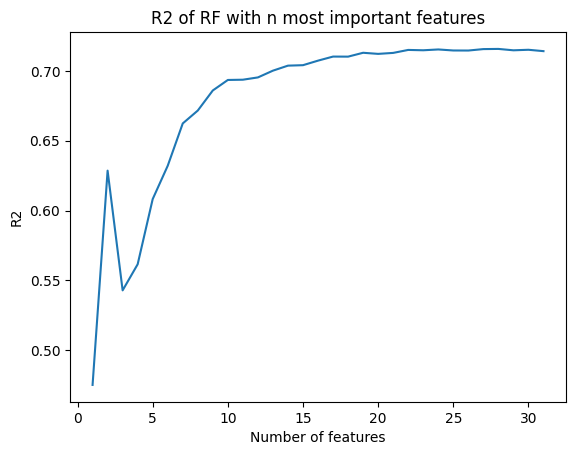

In [71]:
plt.plot(np.arange(1,32), rf_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of RF with n most important features')
plt.show()

In [31]:
try:
    with open('../pickles/rf_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    res = feature_selection_forward_stepwise(RandomForestRegressor(), train_x, train_y)

rf_fs_r2_scores = res['r2_scores']
rf_fs_mse_scores = res['mse_scores']
rf_fs_fitted_features = res['fitted_features']

rf_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': rf_fs_r2_scores, 'mse_scores': rf_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in rf_fs_fitted_features]}) 
print(rf_forward_stepwise_result_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475214    0.475214   5.117586     5.117586   
1                 2  0.631022    0.155808   3.598225    -1.519362   
2                 3  0.647124    0.016102   3.441274    -0.156950   
3                 4  0.652566    0.005442   3.388053    -0.053221   
4                 5  0.661040    0.008474   3.305433    -0.082620   
5                 6  0.666836    0.005796   3.248998    -0.056435   
6                 7  0.671659    0.004824   3.201970    -0.047028   
7                 8  0.673940    0.002280   3.179734    -0.022237   
8                 9  0.674891    0.000951   3.170466    -0.009267   
9                10  0.674383   -0.000507   3.175396     0.004930   
10               11  0.675052    0.000669   3.168917    -0.006480   
11               12  0.675285    0.000232   3.166625    -0.002292   
12               13  0.675299    0.000015   3.166525    -0.000100   
13               14  0.674882   -0

### Support Vector Regression

In [21]:
try:
    with open('../pickles/svm_feature_importances.pickle', 'rb') as handle:
        svm_feature_importances = pickle.load(handle)
except:
    svm_pipe = make_pipeline(StandardScaler(), SVR())
    svm_pipe.fit(train_x, train_y)
    svm_feature_importances = permutation_importance(svm_pipe, train_x, train_y, n_repeats=10, random_state=0)

svm_feature_importance_means = svm_feature_importances.importances_mean
svm_feature_importance_means = pd.Series(svm_feature_importance_means, index=train_x.columns)
svm_feature_importance_means = svm_feature_importance_means.sort_values(ascending=False)
print(svm_feature_importance_means)

NumOfC                          0.315979
NumHBondDonors                  0.248728
NumOfConf                       0.108924
carboxylic acid                 0.099817
hydroperoxide                   0.052929
carbonylperoxyacid              0.043543
peroxide                        0.039652
NumOfAtoms                      0.037386
hydroxyl (alkyl)                0.034224
NumOfConfUsed                   0.028502
carbonylperoxynitrate           0.027450
ketone                          0.027021
NumOfO                          0.026989
MW                              0.025805
C=C (non-aromatic)              0.018720
ether (alicyclic)               0.017582
aldehyde                        0.014066
apin                            0.012137
decane                          0.009644
ester                           0.008706
NumOfN                          0.007333
nitrate                         0.006944
nitro                           0.005804
C=C-C=O in non-aromatic ring    0.004538
toluene         

In [22]:
try:
    with open('../pickles/svm_feature_selection_results.pickle', 'rb') as handle:
        svm_feature_selection_results = pickle.load(handle)
        svm_r2_scores = svm_feature_selection_results['r2_scores']
        svm_mse_scores = svm_feature_selection_results['mse_scores']
except:
    (svm_r2_scores, svm_mse_scores) = feature_selection_importance(svm_feature_importance_means, make_pipeline(StandardScaler(), SVR()), train_x, train_y)

svm_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': svm_r2_scores, 'mse_scores': svm_mse_scores, 'added_feature': svm_feature_importance_means.index})
print(svm_feature_selection_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.114046    0.114046   8.639634     8.639634   
1                 2  0.627052    0.513006   3.636430    -5.003205   
2                 3  0.647806    0.020755   3.434112    -0.202318   
3                 4  0.667918    0.020111   3.238054    -0.196058   
4                 5  0.671564    0.003647   3.202544    -0.035510   
5                 6  0.680302    0.008737   3.117332    -0.085212   
6                 7  0.686329    0.006027   3.058489    -0.058843   
7                 8  0.693831    0.007502   2.985432    -0.073057   
8                 9  0.693304   -0.000527   2.990596     0.005164   
9                10  0.700344    0.007039   2.921899    -0.068698   
10               11  0.710873    0.010530   2.819248    -0.102651   
11               12  0.719707    0.008834   2.733093    -0.086155   
12               13  0.730567    0.010860   2.627275    -0.105818   
13               14  0.731206    0

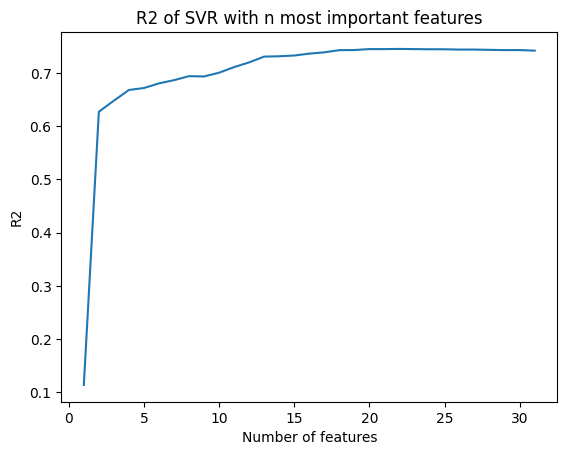

In [56]:
plt.plot(np.arange(1,32), svm_r2_scores)
plt.xlabel('Number of features')
plt.ylabel('R2')
plt.title('R2 of SVR with n most important features')
plt.show()

In [16]:
try:
    with open('../pickles/svm_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    res = feature_selection_forward_stepwise(make_pipeline(StandardScaler(), SVR()), train_x, train_y)

svm_fs_r2_scores = res['r2_scores']
svm_fs_mse_scores = res['mse_scores']
svm_fs_fitted_features = res['fitted_features']

svm_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': svm_fs_r2_scores, 'mse_scores': svm_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in svm_fs_fitted_features]}) 
print(svm_forward_stepwise_result_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475305    0.475305   5.116705     5.116705   
1                 2  0.626821    0.151515   3.639071    -1.477635   
2                 3  0.653222    0.026401   3.381688    -0.257382   
3                 4  0.668501    0.015279   3.232705    -0.148983   
4                 5  0.684542    0.016042   3.076329    -0.156376   
5                 6  0.694098    0.009556   2.983178    -0.093151   
6                 7  0.701392    0.007293   2.911987    -0.071190   
7                 8  0.707706    0.006314   2.850404    -0.061583   
8                 9  0.714695    0.006989   2.782269    -0.068135   
9                10  0.720582    0.005887   2.724843    -0.057426   
10               11  0.725982    0.005400   2.672234    -0.052610   
11               12  0.730781    0.004799   2.625443    -0.046791   
12               13  0.734570    0.003790   2.588441    -0.037002   
13               14  0.736788    0

### Gradient Boosting

In [18]:
try:
    with open('../pickles/gb_feature_importances.pickle', 'rb') as handle:
        gb_feature_importances = pickle.load(handle)
except:
    gb = HistGradientBoostingRegressor()
    gb.fit(train_x, train_y)
    gb_feature_importances = permutation_importance(gb, train_x, train_y, n_repeats=30, random_state=0)

gb_feature_importance_means = gb_feature_importances.importances_mean
gb_feature_importance_means = pd.Series(gb_feature_importance_means, index=train_x.columns)
gb_feature_importance_means = gb_feature_importance_means.sort_values(ascending=False)
print(gb_feature_importance_means)

NumHBondDonors                  0.579891
NumOfC                          0.194672
NumOfConf                       0.146375
carbonylperoxynitrate           0.043520
NumOfConfUsed                   0.035205
carboxylic acid                 0.031621
peroxide                        0.028846
ketone                          0.019975
hydroxyl (alkyl)                0.016425
C=C (non-aromatic)              0.011693
NumOfO                          0.011649
aldehyde                        0.009638
ether (alicyclic)               0.009624
NumOfAtoms                      0.008656
ester                           0.007764
carbonylperoxyacid              0.007314
MW                              0.007097
apin                            0.005561
decane                          0.005146
hydroperoxide                   0.005018
toluene                         0.002488
NumOfN                          0.002435
nitro                           0.001980
nitrate                         0.001524
C=C-C=O in non-a

In [ ]:
try:
    with open('../pickles/gb_feature_selection_results.pickle', 'rb') as handle:
        gb_feature_selection_results = pickle.load(handle)
        gb_r2_scores = gb_feature_selection_results['r2_scores']
        gb_mse_scores = gb_feature_selection_results['mse_scores']
except:
    gb_r2_scores, gb_mse_scores = feature_selection_importance(gb_feature_importance_means, HistGradientBoostingRegressor(), train_x, train_y)

gb_feature_selection_df = get_feature_selection_result_df({
    'r2_scores': gb_r2_scores, 'mse_scores': gb_mse_scores, 'added_feature': gb_feature_importance_means.index})
print(gb_feature_selection_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475076    0.475076   5.118225     5.118225   
1                 2  0.628089    0.153013   3.626297    -1.491927   
2                 3  0.647512    0.019422   3.437017    -0.189281   
3                 4  0.674211    0.026699   3.176896    -0.260121   
4                 5  0.679081    0.004870   3.129349    -0.047547   
5                 6  0.694450    0.015369   2.979443    -0.149906   
6                 7  0.699169    0.004719   2.933436    -0.046006   
7                 8  0.708608    0.009440   2.841480    -0.091956   
8                 9  0.714132    0.005524   2.787573    -0.053907   
9                10  0.719545    0.005413   2.734765    -0.052808   
10               11  0.725632    0.006087   2.675416    -0.059348   
11               12  0.728815    0.003183   2.644460    -0.030957   
12               13  0.731741    0.002926   2.615880    -0.028579   
13               14  0.732299    0

In [ ]:
try:
    with open('../pickles/gb_forward_stepwise_feature_selection_results.pickle', 'rb') as handle:
        res = pickle.load(handle)
except:
    res = feature_selection_forward_stepwise(HistGradientBoostingRegressor(), train_x, train_y)

gb_fs_r2_scores = res['r2_scores']
gb_fs_mse_scores = res['mse_scores']
gb_fs_fitted_features = res['fitted_features']

gb_forward_stepwise_result_df = get_feature_selection_result_df({
    'r2_scores': gb_fs_r2_scores, 'mse_scores': gb_fs_mse_scores, 'added_feature': [x[len(x) - 1] for x in gb_fs_fitted_features]}) 
print(gb_forward_stepwise_result_df)

    Num of features  R2 score  R2 changed  MSE score  MSE changed  \
0                 1  0.475488    0.475488   5.114921     5.114921   
1                 2  0.627881    0.152393   3.628712    -1.486209   
2                 3  0.654405    0.026524   3.370125    -0.258587   
3                 4  0.669295    0.014890   3.224945    -0.145179   
4                 5  0.685692    0.016397   3.065048    -0.159897   
5                 6  0.693628    0.007935   2.987607    -0.077442   
6                 7  0.701302    0.007674   2.912808    -0.074798   
7                 8  0.707130    0.005828   2.855993    -0.056816   
8                 9  0.712582    0.005452   2.802838    -0.053155   
9                10  0.717791    0.005209   2.751966    -0.050872   
10               11  0.723181    0.005390   2.699486    -0.052479   
11               12  0.727457    0.004277   2.657776    -0.041710   
12               13  0.730844    0.003387   2.624739    -0.033037   
13               14  0.733033    0

## Pickle some stuff

In [40]:
with open('../pickles/svm_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(svm_feature_importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [60]:
with open('../pickles/gb_feature_importances.pickle', 'wb+') as handle:
    pickle.dump(gb_feature_importances, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [68]:
with open('../pickles/svm_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': svm_r2_scores, 'mse_scores': svm_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open('../pickles/gb_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': gb_r2_scores, 'mse_scores': gb_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [34]:
with open('../pickles/rf_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'r2_scores': rf_r2_scores, 'mse_scores': rf_mse_scores}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [136]:
with open('../pickles/gb_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': res['fitted_features'], 'r2_scores': res['r2_scores'], 'mse_scores': res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [12]:
with open('../pickles/svm_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': res['fitted_features'], 'r2_scores': res['r2_scores'], 'mse_scores': res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
with open('../pickles/rf_forward_stepwise_feature_selection_results.pickle', 'wb+') as handle:
    pickle.dump({'fitted_features': res['fitted_features'], 'r2_scores': res['r2_scores'], 'mse_scores': res['mse_scores']}, handle, protocol=pickle.HIGHEST_PROTOCOL)